In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error, accuracy_score,classification_report,confusion_matrix,auc, log_loss 

from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dropout, Activation, Flatten,TimeDistributed, BatchNormalization, LeakyReLU, Activation 
from keras.models import Model
from keras.backend import binary_crossentropy
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Preprocessing 

# Skalierung [-1,1]
def scaling(dataset,l_bound=-1, h_bound=1):
    dataset = dataset.reshape(len(dataset), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataset)
    scaled_dataset = scaler.transform(dataset)
    return scaled_dataset

# Umkehrung der Skalierung
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [5]:
ZR_N=scaling(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]
ZR_12=ZR[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]
ZR_46_TR, ZR_46_TE= ZR_46[0:250], ZR_46[250:len(ZR_46)]
ZR_12_TR, ZR_12_TE= ZR_12[0:50], ZR_12[50:len(ZR_12)]

# Anteil der Datensätze am Gesamtdatensatz: skalierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]
ZR_N12=ZR_N[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]
ZR_N46_TR, ZR_N46_TE= ZR_N46[0:250], ZR_N46[250:len(ZR_N46)]
ZR_N12_TR, ZR_N12_TE= ZR_N12[0:50], ZR_N12[50:len(ZR_N12)]

In [7]:
# Funktion zur Erzeugung von y zur Trendvorhersage/Klassifikation t+1: y=(-1,0,1)
def create_Y_trend(dataset):
    dataY=[0]*(len(dataset)-1)
    for i in range(len(dataset)-1):
        a = dataset[i]-dataset[i+1]
        if a<0:
            dataY[i]=1
        elif a>0:
            dataY[i]=-1
        else:
            dataY[i]=0
    return np.array(dataY)

In [8]:
# Funktion zur Weiterentwicklung von Trendergebnissen y(t+1) zu y(t+look_forward) mit look_forward>1
def create_Y_multitrend(dataset,look_forward):
    dataY= create_Y_trend(dataset)
    length=len(dataY)-look_forward+1
    dataY_m=[0]*length 
    dataY_m=np.array(dataY_m)
    for i in range(len(dataY_m)):
        for j in range(look_forward):
            dataY_m[i]= dataY_m[i]+dataY[i+j]
        if dataY_m[i]<0:
            dataY_m[i]=-1
        elif dataY_m[i]>0:
            dataY_m[i]=1
        else:
            dataY_m[i]=0
    return np.array(dataY_m)

In [9]:
# Funktion zur Erzeugung von x (Input) mit look_back (Anzahl der verwendeten Vergangenheitswerte)
def X_to_supervised_T(dataset, look_back=1, look_forward=1):
    df = DataFrame(dataset)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    df = concat(columns, axis=1)
    df = df.drop(0)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-2)]
    DF=df[::-1]
    return DF

In [31]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: t+1
look_back=12
look_forward=1

# Erzeugen von y 

# Dateninput 100%
# Skalierte Daten
trainY_N100=create_Y_trend(ZR_N100_TR)
testY_N100=create_Y_trend(ZR_N100_TE)

# Original Daten
trainY_100=create_Y_trend(ZR_100_TR)
testY_100=create_Y_trend(ZR_100_TE)

# Dateninput 46%
# Skalierte Daten
trainY_N46=create_Y_trend(ZR_N46_TR)
testY_N46=create_Y_trend(ZR_N46_TE)

# Original Daten
trainY_46=create_Y_trend(ZR_46_TR)
testY_46=create_Y_trend(ZR_46_TE)

# Dateninput 12%
# Skalierte Daten
trainY_N12=create_Y_trend(ZR_N12_TR)
testY_N12=create_Y_trend(ZR_N12_TE)

# Original Daten
trainY_12=create_Y_trend(ZR_12_TR)
testY_12=create_Y_trend(ZR_12_TE)

In [32]:
# Erzeugen von X 

# Dateninput: 100%
# Skalierte Daten
trainX_N100=X_to_supervised_T(ZR_N100_TR,look_back,look_forward)
testX_N100=X_to_supervised_T(ZR_N100_TE,look_back,look_forward)

#Originaldaten
trainX_100=X_to_supervised_T(ZR_100_TR,look_back,look_forward)
testX_100=X_to_supervised_T(ZR_100_TE,look_back,look_forward)

# Dateninput: 46%
# Skalierte Daten
trainX_N46=X_to_supervised_T(ZR_N46_TR,look_back,look_forward)
testX_N46=X_to_supervised_T(ZR_N46_TE,look_back,look_forward)

# Originaldaten
trainX_46=X_to_supervised_T(ZR_46_TR,look_back,look_forward)
testX_46=X_to_supervised_T(ZR_46_TE,look_back,look_forward)

# Dateninput: 12%
# Skalierte Daten
trainX_N12=X_to_supervised_T(ZR_N12_TR,look_back,look_forward)
testX_N12=X_to_supervised_T(ZR_N12_TE,look_back,look_forward)

#Originaldaten
trainX_12=X_to_supervised_T(ZR_12_TR,look_back,look_forward)
testX_12=X_to_supervised_T(ZR_12_TE,look_back,look_forward)

In [12]:
# Zuschneiden der Datensätze --> gleiche Länge von X und y

# Dateninput: 100%
# Skalierte Daten
# Trainingsdaten
trainY_N100=trainY_N100.tolist()
trainY_N100=trainY_N100[look_back-1:]
trainY_N100=np.array(trainY_N100)
print(trainX_N100.shape, trainY_N100.shape)
# Testdaten
testY_N100=testY_N100.tolist()
testY_N100=testY_N100[look_back-1:]
testY_N100=np.array(testY_N100)
print(testX_N100.shape, testY_N100.shape)

# Originaldaten
# Trainingsdaten
trainY_100=trainY_100.tolist()
trainY_100=trainY_100[look_back-1:]
trainY_100=np.array(trainY_100)
print(trainX_100.shape, trainY_100.shape)
# Testdaten
testY_100=testY_100.tolist()
testY_100=testY_100[look_back-1:]
testY_100=np.array(testY_100)
print(testX_100.shape, testY_100.shape)

(593, 12) (593,)
(246, 12) (246,)
(593, 12) (593,)
(246, 12) (246,)


In [23]:
# Dateninput: 46%
# Skalierte Daten
# Trainingsdaten
trainY_N46=trainY_N46.tolist()
trainY_N46=trainY_N46[look_back-1:]
trainY_N46=np.array(trainY_N46)
print(trainX_N46.shape, trainY_N46.shape)
# Testdaten
testY_N46=testY_N46.tolist()
testY_N46=testY_N46[look_back-1:]
testY_N46=np.array(testY_N46)
print(testX_N46.shape, testY_N46.shape)

# Originaldaten
# Trainingsdaten
trainY_46=trainY_46.tolist()
trainY_46=trainY_46[look_back-1:]
trainY_46=np.array(trainY_46)
print(trainX_46.shape, trainY_46.shape)
# Testdaten
testY_46=testY_46.tolist()
testY_46=testY_46[look_back-1:]
testY_46=np.array(testY_46)
print(testX_46.shape, testY_46.shape)

(238, 12) (238,)
(138, 12) (138,)
(238, 12) (238,)
(138, 12) (138,)


In [33]:
# Dateninput: 12%
# Skalierte Daten

# Trainingsdaten
trainY_N12=trainY_N12.tolist()
trainY_N12=trainY_N12[look_back-1:]
trainY_N12=np.array(trainY_N12)
print(trainX_N12.shape, trainY_N12.shape)
# Testdaten
testY_N12=testY_N12.tolist()
testY_N12=testY_N12[look_back-1:]
testY_N12=np.array(testY_N12)
print(testX_N12.shape, testY_N12.shape)

# Originaldaten
# Trainingsdaten
trainY_12=trainY_12.tolist()
trainY_12=trainY_12[look_back-1:]
trainY_12=np.array(trainY_12)
print(trainX_12.shape, trainY_12.shape)
# Testdaten
testY_12=testY_12.tolist()
testY_12=testY_12[look_back-1:]
testY_12=np.array(testY_12)
print(testX_12.shape, testY_12.shape)

(38, 12) (38,)
(38, 12) (38,)
(38, 12) (38,)
(38, 12) (38,)


In [13]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [14]:
# Modell zusammenbauen
# Dateninput: 100 %
model = Sequential()
model.add(Dense(6, input_dim=look_back, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1,activation='tanh'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_trend=model.fit(trainX_N100, trainY_N100, epochs=2, batch_size=10, verbose=2, validation_data=(testX_N100, testY_N100))

Train on 593 samples, validate on 246 samples
Epoch 1/2
 - 1s - loss: -6.9684e-01 - binary_accuracy: 0.0169 - val_loss: 0.1106 - val_binary_accuracy: 0.0000e+00
Epoch 2/2
 - 0s - loss: -5.7059e-01 - binary_accuracy: 0.0118 - val_loss: -8.9966e-03 - val_binary_accuracy: 0.0000e+00


Text(0.5,1,'Loss Curves')

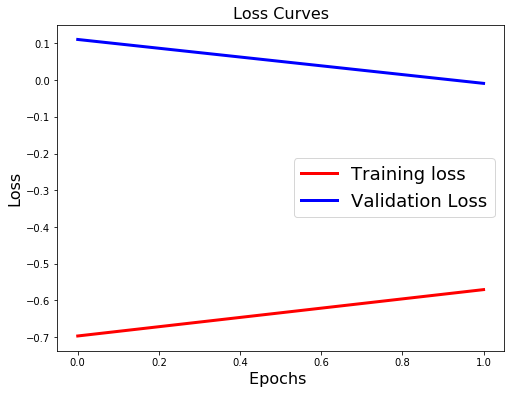

In [15]:
#Plotten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['loss'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

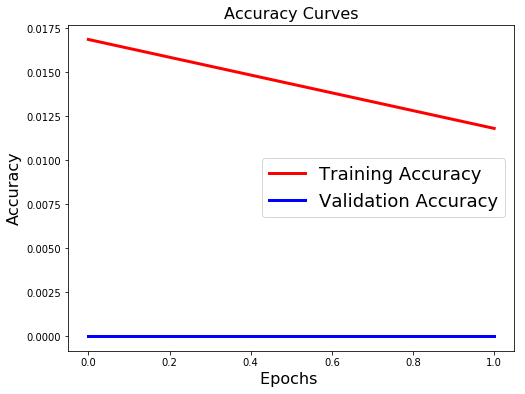

In [16]:
#Ploten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['binary_accuracy'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_binary_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [17]:
# Vorhersage generieren
trainPredict_100 = model.predict(trainX_100)
testPredict_100 = model.predict(testX_100)

trainPredict_100_c=model.predict_classes(trainX_100)
testPredict_100_c=model.predict_classes(testX_100)

In [18]:
# Modellperformance bewerten
def classification(dataset):
    for i in range(len(dataset)):
        if dataset[i]>= 0.05:
            dataset[i]=1
        elif dataset[i]<= -0.05:
            dataset[i]=-1
        else:
            dataset[i]=0
    return dataset

In [19]:
testPredict_100_C=classification(testPredict_100)
trainPredict_100_C=classification(trainPredict_100)

In [20]:
accuracy_score(testY_N100, testPredict_100)

0.508130081300813

In [24]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [25]:
# Modell zusammenbauen
# Dateninput: 46 %
model = Sequential()
model.add(Dense(6, input_dim=look_back, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1,activation='tanh'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_trend=model.fit(trainX_N46, trainY_N46, epochs=2, batch_size=10, verbose=2, validation_data=(testX_N46, testY_N46))

Train on 238 samples, validate on 138 samples
Epoch 1/2
 - 1s - loss: -1.0007e+00 - binary_accuracy: 0.0042 - val_loss: -2.0323e-01 - val_binary_accuracy: 0.0000e+00
Epoch 2/2
 - 0s - loss: -1.1162e+00 - binary_accuracy: 0.0000e+00 - val_loss: -1.4144e-01 - val_binary_accuracy: 0.0000e+00


Text(0.5,1,'Loss Curves')

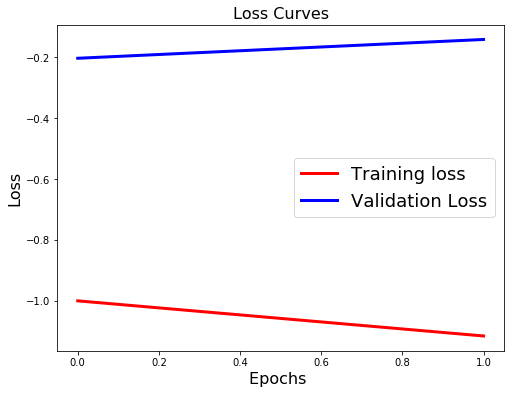

In [26]:
#Plotten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['loss'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

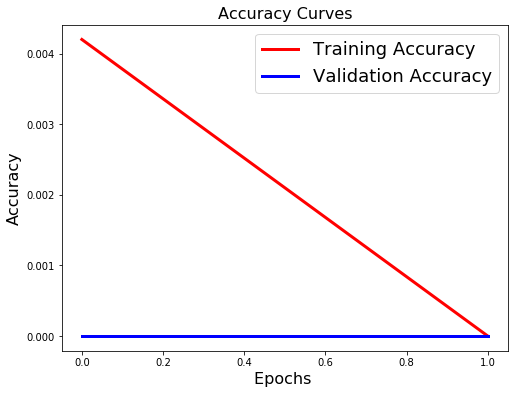

In [27]:
#Ploten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['binary_accuracy'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_binary_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [28]:
# Vorhersage generieren
trainPredict_46 = model.predict(trainX_46)
testPredict_46 = model.predict(testX_46)

In [29]:
testPredict_46_C=classification(testPredict_46)
trainPredict_46_C=classification(trainPredict_46)

In [30]:
accuracy_score(testY_N46, testPredict_46)

0.5072463768115942

In [34]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [35]:
# Modell zusammenbauen
# Dateninput: 12 %
model = Sequential()
model.add(Dense(6, input_dim=look_back, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1,activation='tanh'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_trend=model.fit(trainX_N12, trainY_N12, epochs=20, verbose=2, validation_data=(testX_N12, testY_N12))

Train on 38 samples, validate on 38 samples
Epoch 1/20
 - 1s - loss: -8.9675e-01 - binary_accuracy: 0.0000e+00 - val_loss: -1.1281e+00 - val_binary_accuracy: 0.0263
Epoch 2/20
 - 0s - loss: -1.1266e+00 - binary_accuracy: 0.0000e+00 - val_loss: -1.1751e+00 - val_binary_accuracy: 0.0000e+00
Epoch 3/20
 - 0s - loss: -1.4703e+00 - binary_accuracy: 0.0000e+00 - val_loss: -1.0208e+00 - val_binary_accuracy: 0.0000e+00
Epoch 4/20
 - 0s - loss: -5.9518e-01 - binary_accuracy: 0.0000e+00 - val_loss: -1.0103e+00 - val_binary_accuracy: 0.0000e+00
Epoch 5/20
 - 0s - loss: -2.7318e-01 - binary_accuracy: 0.0000e+00 - val_loss: -1.0193e+00 - val_binary_accuracy: 0.0000e+00
Epoch 6/20
 - 0s - loss: -5.7168e-01 - binary_accuracy: 0.0000e+00 - val_loss: -1.0541e+00 - val_binary_accuracy: 0.0000e+00
Epoch 7/20
 - 0s - loss: -1.0205e+00 - binary_accuracy: 0.0000e+00 - val_loss: -1.6475e+00 - val_binary_accuracy: 0.0000e+00
Epoch 8/20
 - 0s - loss: -1.4605e+00 - binary_accuracy: 0.0000e+00 - val_loss: -1.403

Text(0.5,1,'Loss Curves')

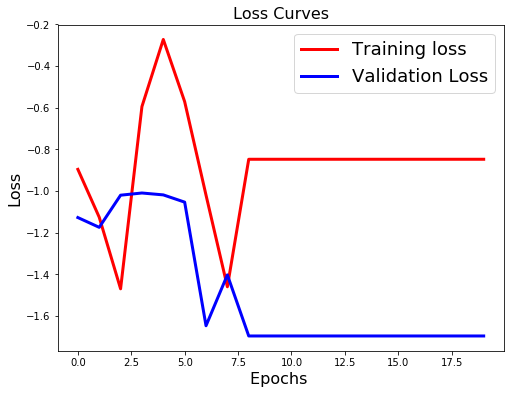

In [36]:
#Plotten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['loss'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

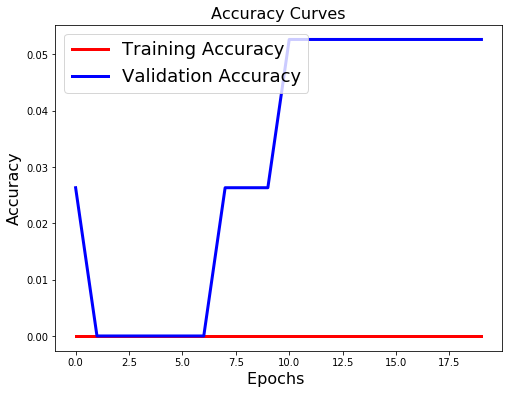

In [37]:
#Ploten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['binary_accuracy'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_binary_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [38]:
# Vorhersage generieren
trainPredict_12 = model.predict(trainX_12)
testPredict_12 = model.predict(testX_12)

In [39]:
testPredict_12_C=classification(testPredict_12)
trainPredict_12_C=classification(trainPredict_12)

In [40]:
accuracy_score(testY_N12, testPredict_12)

0.5526315789473685